In [4]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt

In [5]:
torch.manual_seed(111)

## Preparing the Training data

In [6]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length) # random from 0 to 2 pi
train_data[:, 1] = torch.sin(train_data[:, 0]) # sine of first column
train_labels = torch.zeros(train_data_length) # a tensor filled with zeros since labels can be anything
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
] # list of tuples

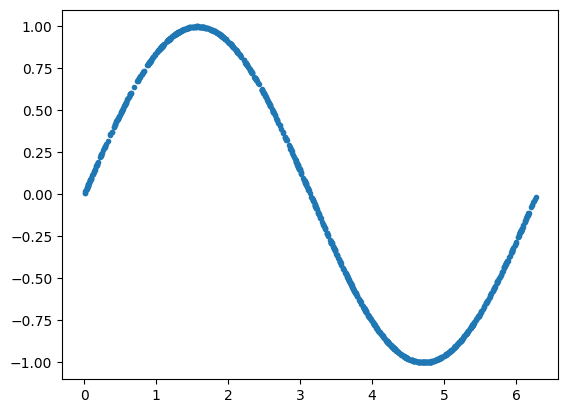

In [7]:
# Lets check by plotting
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [8]:
# Pytorch data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
) # shuffles the data from the train set and returns batches of 32 samples

## Implementing the Discriminator

In [9]:
# class inherited from nn.Module class
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__() # to run constructor from nn.Module
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3), # to avoid overfitting
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [10]:
discriminator = Discriminator()

## Implementing the Generator

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

## Training the Model

In [13]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss() # BCE = binary cross entropy (suitable for binary classification)

In [14]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [15]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        # concatenate generated sample labels and real sample labels
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward() # calculate gradients to update the weights
        optimizer_discriminator.step() # update discriminator weights

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.21308742463588715
Epoch: 0 Loss G.: 1.7989581823349
Epoch: 10 Loss D.: 0.6099681258201599
Epoch: 10 Loss G.: 0.907738447189331
Epoch: 20 Loss D.: 0.6200771927833557
Epoch: 20 Loss G.: 0.9532098770141602
Epoch: 30 Loss D.: 0.657402753829956
Epoch: 30 Loss G.: 0.7882198691368103
Epoch: 40 Loss D.: 0.6602703928947449
Epoch: 40 Loss G.: 0.794442355632782
Epoch: 50 Loss D.: 0.7171382904052734
Epoch: 50 Loss G.: 0.6153948307037354
Epoch: 60 Loss D.: 0.7692908048629761
Epoch: 60 Loss G.: 0.6501925587654114
Epoch: 70 Loss D.: 0.6779373288154602
Epoch: 70 Loss G.: 0.6782472729682922
Epoch: 80 Loss D.: 0.6619732975959778
Epoch: 80 Loss G.: 0.742807149887085
Epoch: 90 Loss D.: 0.6718282103538513
Epoch: 90 Loss G.: 0.7446345686912537
Epoch: 100 Loss D.: 0.7242525815963745
Epoch: 100 Loss G.: 0.6958509683609009
Epoch: 110 Loss D.: 0.6346588134765625
Epoch: 110 Loss G.: 0.9347332715988159
Epoch: 120 Loss D.: 0.7041670680046082
Epoch: 120 Loss G.: 0.7560363411903381
Epoch: 130 Los

## Verification

In [16]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples) # obtain generated samples

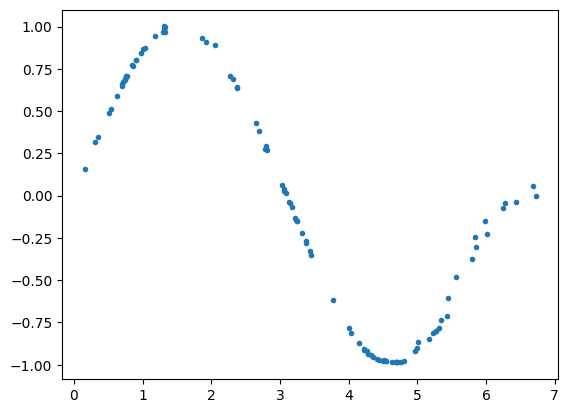

In [18]:
generated_samples = generated_samples.detach() # return a tensor from the Pytorch computational graph
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")